In [ ]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline


###### 1.Optimise the following function using torch autograd and gradient descent, f(θ) = (θ₀ - 2)² + (θ₁ - 3)². In addition to finding the optima, you need to show the convergence plots. [0.5 marks]



###### 3.Generate some data (1000 data points) using a univariate Normal distribution with loc=2.0 and scale=4.0 and using Student-T distributions with varying degrees (from 1-8) of freedom (1000 data points corresponding to each degree of freedom). Plot the pdf (and logpdf) at uniformly spaced data from (-50, 50) in steps of 0.1. What can you conclude? [1 mark]

###### 4.Analytically derive the MLE for exponential distribution. Generate some data (1000 data points) using some fixed parameter values and see if you can recover the analytical parameters using gradient descent based solution for obtaining MLE. [1 mark]

###### 5.Generate some data (100 data points) using a univariate Normal distribution with loc=2.0 and scale=4.0. Now, create datasets of size 10, 20, 50, 100, 500, 1000, 5000, 10000. We will use a different random seed to create ten different datasets for each of these sizes. For each of these datasets, find the MLE parameters for the loc and scale using gradient descent. Plot the estimates of loc and scale as a function of the dataset size. What can you conclude? [1 mark]

# Question 1:

In [ ]:
# Define the function
def f(theta):
    return (theta[0] - 2)**2 + (theta[1] - 3)**2


In [ ]:

# Initialize the parameters (θ₀ and θ₁) and learning rate
theta = torch.tensor([ random.random() ,random.random()], requires_grad=True)
learning_rate = 0.1
num_iterations = 100
theta

In [ ]:
loss_history = []
theta_history = []

for _ in range(num_iterations):
    loss = f(theta)
    # print(loss.item())
    loss_history.append(loss.item())
    theta_history.append(theta)
    # print(theta)
    loss.backward()  # Compute gradients
    with torch.no_grad():
        theta -= learning_rate * theta.grad  # Update parameters
        theta.grad.zero_()  # Reset gradients

In [ ]:
plt.plot(range(num_iterations), loss_history, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Convergence Plot')
plt.legend()
plt.show()

In [ ]:
optimal_theta = theta.detach().numpy()
print("Optimal Parameters (θ₀, θ₁):", optimal_theta)
print("Optimal Value of f(θ):", f(optimal_theta))

###### 2.Generate some data (100 data points) using a univariate Normal distribution with loc=2.0 and scale=4.0.

Plot a 2d contour plot showing the Likelihood or the Log-Likelihood as a function of loc and scale. Please label all the axes including the colorbar. [1 mark]

Find the MLE parameters for the loc and scale using gradient descent. Plot convergence plot as well. [1 mark]

Redo the above question but learn log(scale) instead of scale and then finally transform to learn scale. What can you conclude? Why is this transformation useful? [0.5 mark]

In [ ]:
N = 100
torch.manual_seed(2)
samples = torch.distributions.Normal(2.0, 4.0).sample((N,))
samples
samples.mean(), samples.std(correction=0)
plt.scatter(range(N),samples,color='g',label='datapoint')
plt.xlabel('index')
plt.ylabel('values')
plt.legend();

In [ ]:
#Plot a 2d contour plot showing the Likelihood or the Log-Likelihood as a function of loc and scale. Please label all the axes including the colorbar. [1 mark]
def ll(mu, sigma):
    mu = torch.tensor(mu)
    sigma = torch.tensor(sigma)
    dist = torch.distributions.Normal(mu, sigma)
    loglik = dist.log_prob(samples).sum()
    return dist, loglik
   

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_lls(mus, sigmas, lls):
    fig, ax1 = plt.subplots(figsize=(8, 6))
    
    X, Y = np.meshgrid(mus, sigmas)
    
    max_indices = np.unravel_index(np.argmax(lls), lls.shape)
    max_mu = mus[max_indices[1]]
    max_sigma = sigmas[max_indices[0]]
    max_loglik = lls[max_indices]

    # Define levels with increasing granularity
    levels_low = np.linspace(lls.min(), max_loglik, 20)
    levels_high = np.linspace(max_loglik + 0.001, lls.max(), 10)  # Adding a small value to prevent duplicates
    levels = levels_low
    
    # Plot the contour filled plot
    contour = ax1.contourf(X, Y, lls.T, levels=levels, cmap='magma')
    
    # Plot the contour lines
    contour_lines = ax1.contour(X, Y, lls.T, levels=levels, colors='black', linewidths=0.5, alpha=0.6)
    
    # Add contour labels
    ax1.clabel(contour_lines, inline=True, fontsize=10, colors='black', fmt='%1.2f')
    
    ax1.set_xlabel('Mu')
    ax1.set_ylabel('Sigma')
    ax1.set_title('Contour Plot of Log Likelihood')
    
    # Add maximum log likelihood point as scatter on the contour plot
    ax1.scatter([max_mu], [max_sigma], color='red', marker='o', label='Maximum Log Likelihood')
    ax1.annotate(f'Max LL: {max_loglik:.2f}', (max_mu, max_sigma), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

    ax1.axvline(max_mu, color='red', linestyle='--', alpha=0.5)
    ax1.axhline(max_sigma, color='red', linestyle='--', alpha=0.5)
    
    # Create colorbar outside the plot
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(contour, cax=cax)
    cbar.set_label('Log Likelihood', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()



In [ ]:
def get_lls(mus, sigmas):

    lls = torch.zeros((len(mus), len(sigmas)))
    for i, mu in enumerate(mus):
        for j, sigma in enumerate(sigmas):

            lls[i, j] = ll(mu, sigma)[1]
    return lls

In [ ]:
mus = torch.linspace(1.5, 2.5, 100)
sigmas = torch.linspace(3.5, 4.5,100)
lls = get_lls(mus, sigmas)
plot_lls(mus, sigmas, lls)

In [ ]:
def ll_func(samples,loc,scale):
    y = (len(samples)/2)*torch.log(2*torch.pi*(scale**2)) + (1/(2*(scale**2)))*torch.sum((samples - loc)**2)
    return y

In [ ]:

loc = torch.tensor(random.random(), requires_grad=True)
scale = torch.tensor(random.random(), requires_grad=True)
# Gradient descent loop
n_epochs = 1000
optimizer = torch.optim.SGD([loc,scale], lr=0.0005)
out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = ll_func(samples,loc,scale)
    # print(loc,scale,out)
    out.backward()
    optimizer.step()
    out_list.append(out.detach().numpy())
    
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(range(n_epochs),out_list,label="Log Likelihood")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Function Value")
ax.legend()
plt.show()

print(f"Estimated mu is:{loc.detach().numpy()} and sigma is: {scale.detach().numpy()}")

In [ ]:
def ll_func_log_scale(samples,loc,log_scale):
    y = (len(samples)/2)*torch.log(2*math.pi*(torch.exp(log_scale)**2)) + (1/(2*(torch.exp(log_scale)**2)))*torch.sum((samples - loc)**2)
    return y

In [ ]:

loc = torch.tensor(random.random(), requires_grad=True)
log_scale = torch.tensor(random.random(), requires_grad=True)
# Gradient descent loop
n_epochs = 1000
optimizer = torch.optim.SGD([loc,log_scale], lr=0.0005)
out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = ll_func_log_scale(samples,loc,log_scale)
    # print(loc,scale,out)
    out.backward()
    optimizer.step()
    out_list.append(out.detach().numpy())
    
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(range(n_epochs),out_list,label="Log Likelihood")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Function Value")
ax.legend()
plt.show()

print(f"Estimated mu is:{loc.detach().numpy()} and sigma is: {log_scale.detach().numpy()}")

In [ ]:
torch.exp(log_scale)

Conclusion: During the process of finding the Maximum Likelihood Estimation (MLE) parameters for the (loc) and scale using gradient descent, the parameters do not converge effectively, and their values cannot be consistently reproduced. However, when employing a Log scale, numerical stability is enhanced, resulting in consistent and reproducible values.

  

# Question 3:

In [ ]:
normal = torch.distributions.Normal(loc=2, scale=4)
# samples = normal.sample((1000,))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
xs = torch.linspace(-50, 50,1001)
y_logpdf = normal.log_prob(xs)
y_pdf = normal.log_prob(xs).exp()
fig.suptitle(f'LogPDF and PDF for Normal dist with loc=2 and scale=4:', fontsize=20)
ax[0].plot(xs,y_logpdf)
ax[0].set_xlabel("Sample value")
ax[0].set_ylabel("Log(Probability density function)")
ax[1].plot(xs,y_pdf)
ax[1].set_xlabel("Sample value")
ax[1].set_ylabel("Probability density function")
plt.show()
# plt.scatter(samples, np.zeros_like(samples))

In [ ]:
import torch
import matplotlib.pyplot as plt

# Create a range of degrees of freedom
dfs = range(1, 9)

fig, ax = plt.subplots(1,2,figsize=(10, 6))

for df in dfs:
    dist = torch.distributions.studentT.StudentT(df=df)
    xs = torch.linspace(-50, 50, 1001)
    y_logpdf = dist.log_prob(xs)
    y_pdf = y_logpdf.exp()

    ax[0].plot(xs, y_logpdf, label=f'df = {df} (LogPDF)')
    ax[0].set_title("LogPDF for Student's t-distribution")
    ax[0].set_xlabel("Sample value")
    ax[0].set_ylabel("Probability density")
    ax[0].legend()
    ax[1].plot(xs, y_pdf, linestyle='dashed', label=f'df = {df} (PDF)')
    ax[1].set_title("PDF for Student's t-distribution")
    ax[1].set_xlabel("Sample value")
    ax[1].set_ylabel("Probability density")
    ax[1].legend();


# Conclusion from the graphs



With increasing degrees of freedom, the pdf values are almost similar at the peaks and difficult to differentiate across DoF due to floating point precision. While the pdf values are zeroed for the samples at the tails due to underflow.
For logPDF values even at tails or near the peaks, values with varying DoF have significant differences and are not zeroed.

# Question 4

In [ ]:
n_samples = 1000
exp_dist = torch.distributions.exponential.Exponential(rate=1)
samples = exp_dist.sample((n_samples,))

In [ ]:
plt.scatter(range(n_samples),samples)

In [ ]:
def func(x,log_rate):
    y = -log_rate + (torch.exp(log_rate)*x)
    return y

In [ ]:
log_rate = torch.tensor(random.random(), requires_grad=True)
# Gradient descent loop
n_epochs = 200
optimizer = torch.optim.SGD([log_rate], lr=0.0001)
out_list = []
for epoch_itr in range(n_epochs):
    optimizer.zero_grad()
    out = torch.sum(func(samples,log_rate))
    print(log_rate,out)
    
    out.backward()
    optimizer.step()
    out_list.append(out.detach().numpy())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(range(n_epochs),out_list)
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Function Value")
plt.show()

In [ ]:
print(f"Analytical value of rate: {n_samples/sum(samples)}, Rate optimised using SGD: {math.exp(log_rate)}")

# Question 5

In [ ]:
def ll_func(samples,loc,scale):
    y = (len(samples)/2)*torch.log(2*torch.pi*(scale**2)) + (1/(2*(scale**2)))*torch.sum((samples - loc)**2)
    return y

In [54]:
n_samples_list = [10, 20, 50, 100, 500, 1000, 5000, 10000] 
seed_list = list(range(5))
est_loc_list = []
est_scale_list = []
for n_sample in n_samples_list:
    print("----------------------------------------")
    print(f"Number of samples: {n_sample}")
    loc_list = []
    scale_list = []
    for seed in seed_list:
        # generate samples from distribution
        torch.manual_seed(seed)
        norm_dist = torch.distributions.Normal(loc=2, scale=4)
        samples = norm_dist.sample((n_sample,))
        
        # 
        loc = torch.tensor(random.random(), requires_grad=True)
        scale = torch.tensor(random.random(), requires_grad=True)
        # Gradient descent loop
        n_epochs = 10000
        optimizer = torch.optim.Adam([loc,scale],lr=0.001)
        out_list = []
        for epoch_itr in range(n_epochs):
            optimizer.zero_grad()
            out = ll_func(samples,loc,scale)
#             print(loc,scale,out)
            out.backward()
            optimizer.step()
            out_list.append(out.detach().numpy())
            
#         fig, ax = plt.subplots(1, 1, figsize=(10, 4))
#         ax.plot(range(n_epochs),out_list,linestyle = 'dotted')
#         ax.set_xlabel("Number of Epochs")
#         ax.set_ylabel("Function Value")
#         plt.show()
        loc_list.append(loc.detach().numpy())
        scale_list.append(scale.detach().numpy())
    
        print(f"From Gradient Descent, Estimated mu is:{loc.detach().numpy()} and sigma is: {scale.detach().numpy()}")
        print(f"Analytically, Estimated mu is:{sum(samples)/n_sample} and sigma is: {(sum((samples-sum(samples)/n_sample)**2)/n_sample)**0.5}")
    
    est_loc_list.append(loc_list)
    est_scale_list.append(scale_list)

----------------------------------------
Number of samples: 10


From Gradient Descent, Estimated mu is:0.9091446995735168 and sigma is: 3.929197072982788
Analytically, Estimated mu is:0.9091453552246094 and sigma is: 4.282902240753174
From Gradient Descent, Estimated mu is:1.304591178894043 and sigma is: 2.7181289196014404
Analytically, Estimated mu is:1.3045953512191772 and sigma is: 2.7321977615356445
From Gradient Descent, Estimated mu is:1.4939578771591187 and sigma is: 2.81455397605896
Analytically, Estimated mu is:1.4939601421356201 and sigma is: 2.8147473335266113
From Gradient Descent, Estimated mu is:2.0088415145874023 and sigma is: 3.208085298538208
Analytically, Estimated mu is:2.0088624954223633 and sigma is: 3.36712908744812
From Gradient Descent, Estimated mu is:2.7941274642944336 and sigma is: 0.487662672996521
Analytically, Estimated mu is:3.4143900871276855 and sigma is: 4.521202564239502
----------------------------------------
Number of samples: 20
From Gradient Descent, Estimated mu is:3.37868595123291 and sigma is: 3.2993741035

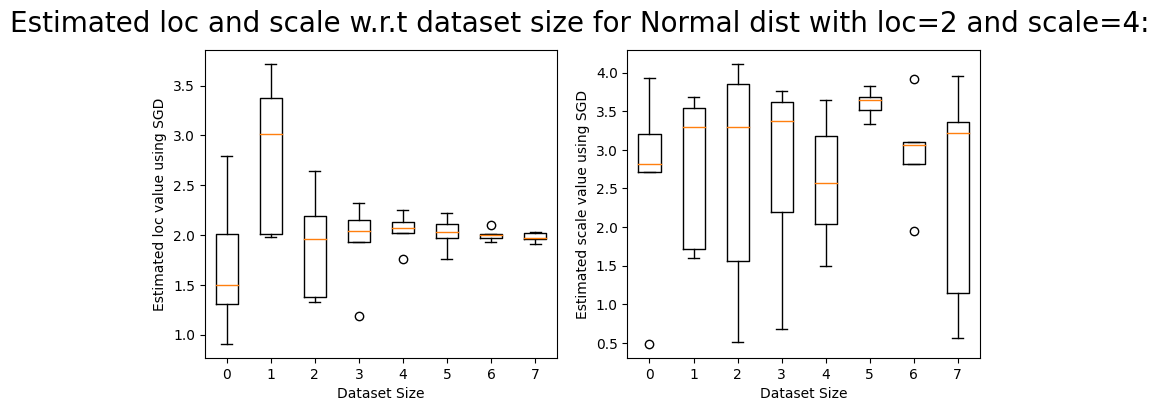

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'Estimated loc and scale w.r.t dataset size for Normal dist with loc=2 and scale=4:', fontsize=20)
ax[0].boxplot(est_loc_list, positions=range(len(n_samples_list)))
# ax[0].plot(n_samples_list,est_loc_list)
ax[0].set_xlabel("Dataset Size")
ax[0].set_ylabel("Estimated loc value using SGD")
ax[1].boxplot(est_scale_list, positions=range(len(n_samples_list)))
ax[1].set_xlabel("Dataset Size")
ax[1].set_ylabel("Estimated scale value using SGD")
plt.show()